In [92]:
import sys
import os
sys.path.append("../../core/datasets")

from old_pfdelta_dataset import PFDeltaDataset

import torch
from torch_geometric.datasets import OPFDataset
import pandas 
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import random 
import matplotlib.patches as mpatches
from data_utils import loadcase 
from idx import *
import seaborn as sns

In [93]:
case_info = {
    "case14": {
        "num_samples": 10000,
        "num_buses": 14,
        "num_loads": 11,
        "num_gens": 5,
        "x_ticks": 5,
        "case_path": "../pglib/pglib_opf_case14_ieee.m",
        "opfdata_args":"pglib_opf_case14_ieee"
    },
    "case118": {
        "num_samples": 10000,
        "num_buses": 118,
        "num_loads": 99,
        "num_gens": 54,
        "x_ticks": 5,
        "case_path": "../pglib/pglib_opf_case118_ieee.m",
        "opfdata_args":"pglib_opf_case118_ieee"
    },
    "case57": {
        "num_samples": 10000,
        "num_buses": 57,
        "num_loads": 42,
        "num_gens": 7,
        "x_ticks": 5,
        "case_path": "../pglib/pglib_opf_case57_ieee.m",
        "opfdata_args":"pglib_opf_case57_ieee"
    }
}

In [94]:
# Choose a case
selected_case = "case14"

# Access its info
info = case_info[selected_case]

# Now you can use it as individual variables
num_samples = info["num_samples"]
num_buses   = info["num_buses"]
num_loads   = info["num_loads"]
num_gens    = info["num_gens"]
x_ticks     = info["x_ticks"]
case_path   = info["case_path"]

In [95]:
# Useful stuff for plots
mpc = loadcase(case_path)
spv_mask = (mpc["bus"][:, BUS_TYPE] == 2) | (mpc["bus"][:, BUS_TYPE] == 3)
vmin_array = mpc["bus"][:, VMIN]   # shape (num_buses,)
vmax_array = mpc["bus"][:, VMAX]

In [96]:
# Load new_PFDelta without seed expansion
root = '../my_results/2025-05-06_10-45-31' # double-check path
pfdelta_dataset_no_exp = PFDeltaDataset(
    root_dir=root,
    split='all', 
    case_name=selected_case + "_n", # verify path here,
    # topological_perturbations=True, # this has to be added to the class: have it load the correct perturbation?
    force_reload=False
)

# remains to be seen if it will work exactly like this.
pg_full = torch.zeros((num_samples, num_buses))
qg_full = torch.zeros((num_samples, num_buses))
pd = torch.zeros((num_samples, num_loads))
qd = torch.zeros((num_samples, num_loads))
vm = torch.zeros((num_samples, num_buses))
va = torch.zeros((num_samples, num_buses))

for i in range(num_samples):
    pg = pfdelta_dataset_no_exp[i]['gen']['generation'][:, 0]
    qg = pfdelta_dataset_no_exp[i]['gen']['generation'][:, 1]
    gen_bus = pfdelta_dataset_no_exp[i]["gen", "gen_link", "bus"]['edge_index'][1, :]
    pg_full[i, :].scatter_add_(0, gen_bus, pg)
    qg_full[i, :].scatter_add_(0, gen_bus, qg)

    pd[i, :] =  pfdelta_dataset_no_exp[i]['load']['demand'][:, 0]
    qd[i, :] = pfdelta_dataset_no_exp[i]['load']['demand'][:, 1]
    vm[i, :] = pfdelta_dataset_no_exp[i]['bus']['bus_voltages'][:, 1]
    va[i, :] = pfdelta_dataset_no_exp[i]['bus']['bus_voltages'][:, 0]

pg = pg_full[:, spv_mask]
qg = qg_full[:, spv_mask]

new_pfdelta_no_exp = {'pd': pd, 'qd': qd, 'pg': pg, 'qg': qg, 'vm': vm, 'va': va}

/Users/anarivera/opt/miniconda3/envs/delta_pf/lib/python3.10/site-packages/torch_geometric/io/fs.py:229: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([BaseStorage])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "


In [97]:
# Load new_PFDelta with seed expansion
root = os.path.join("..","seed_exp_data", selected_case + "_seeds")
pfdelta_dataset_w_exp = PFDeltaDataset(
    root_dir=root,
    split='all', 
    case_name="none/", # verify path here,
    # topological_perturbations=True, # this has to be added to the class: have it load the correct perturbation?
    force_reload=False
)

# remains to be seen if it will work exactly like this.
pg_full = torch.zeros((num_samples, num_buses))
qg_full = torch.zeros((num_samples, num_buses))
pd = torch.zeros((num_samples, num_loads))
qd = torch.zeros((num_samples, num_loads))
vm = torch.zeros((num_samples, num_buses))
va = torch.zeros((num_samples, num_buses))

for i in range(num_samples):
    pg = pfdelta_dataset_w_exp[i]['gen']['generation'][:, 0]
    qg = pfdelta_dataset_w_exp[i]['gen']['generation'][:, 1]
    gen_bus = pfdelta_dataset_w_exp[i]["gen", "gen_link", "bus"]['edge_index'][1, :]
    pg_full[i, :].scatter_add_(0, gen_bus, pg)
    qg_full[i, :].scatter_add_(0, gen_bus, qg)

    pd[i, :] =  pfdelta_dataset_w_exp[i]['load']['demand'][:, 0]
    qd[i, :] = pfdelta_dataset_w_exp[i]['load']['demand'][:, 1]
    vm[i, :] = pfdelta_dataset_w_exp[i]['bus']['bus_voltages'][:, 1]
    va[i, :] = pfdelta_dataset_w_exp[i]['bus']['bus_voltages'][:, 0]

pg = pg_full[:, spv_mask]
qg = qg_full[:, spv_mask]

new_pfdelta_w_exp = {'pd': pd, 'qd': qd, 'pg': pg, 'qg': qg, 'vm': vm, 'va': va}

In [98]:
# Load OPFData
root = '../opfdata'
opfdata_dataset = OPFDataset(
    root=root,
    num_groups=1, 
    split='train', 
    case_name=info["opfdata_args"], 
    topological_perturbations=True,
    force_reload=False
)

pg_full = torch.zeros((num_samples, num_buses))
qg_full = torch.zeros((num_samples, num_buses))
pd = torch.zeros((num_samples, num_loads))
qd = torch.zeros((num_samples, num_loads))
vm = torch.zeros((num_samples, num_buses))
va = torch.zeros((num_samples, num_buses))

for i in range(num_samples):
    pg = opfdata_dataset[i]['generator']['y'][:, 0]
    qg = opfdata_dataset[i]['generator']['y'][:, 1]
    gen_bus = opfdata_dataset[i]["generator", "generator_link", "bus"]['edge_index'][1, :]
    pg_full[i, :].scatter_add_(0, gen_bus, pg)
    qg_full[i, :].scatter_add_(0, gen_bus, qg)
    pd[i, :] =  opfdata_dataset[i]['load']['x'][:, 0]
    qd[i, :] = opfdata_dataset[i]['load']['x'][:, 1]
    vm[i, :] = opfdata_dataset[i]['bus']['y'][:, 1]
    va[i, :] = opfdata_dataset[i]['bus']['y'][:, 0]

pg = pg_full[:, spv_mask]
qg = qg_full[:, spv_mask]

opfdata = {'pd': pd, 'qd': qd, 'pg': pg, 'qg': qg, 'vm': vm, 'va': va}

In [99]:
# Load OPFLearn CSV
opflearn_path = os.path.join("..", "opflearn", selected_case, info["opfdata_args"] + ".csv")
df = pandas.read_csv(opflearn_path)

# Load pd, qd as torch tensors
pd = torch.tensor(df.filter(regex=r'^load\d+:pl$', axis=1).to_numpy(), dtype=torch.float32)
qd = torch.tensor(df.filter(regex=r'^load\d+:ql$', axis=1).to_numpy(), dtype=torch.float32)

# Load pg, qg as torch tensors
pg = torch.tensor(df.filter(regex=r'^gen\d+:pg$', axis=1).to_numpy(), dtype=torch.float32)
qg = torch.tensor(df.filter(regex=r'^gen\d+:qg$', axis=1).to_numpy(), dtype=torch.float32)
# Extract complex bus voltages from dataframe
vm_df = df.filter(regex=r'^bus\d+:v_bus$', axis=1)

def safe_complex(val):
    if isinstance(val, str):
        val = val.replace(" + ", "+").replace(" - ", "-")
        try:
            return complex(val)
        except ValueError:
            return np.nan
    return val if isinstance(val, complex) else np.nan

# Parse v_bus strings into complex numbers
vm_complex = vm_df.applymap(safe_complex).to_numpy()

# 🔧 FIX: Correct angle encoding by scaling angle by -180/pi
v_bus_corrected = np.abs(vm_complex) * np.exp(1j * -np.degrees(np.angle(vm_complex)))

# Convert corrected values to torch tensors
vm = torch.tensor(np.abs(v_bus_corrected), dtype=torch.float32)
va = torch.tensor(np.angle(v_bus_corrected), dtype=torch.float32)

# Infer shape
num_samples, num_buses = vm.shape
num_gens = pg.shape[1]

# Expand gen_bus for broadcasting
gen_bus = mpc['gen'][:, GEN_BUS].to(torch.long)
gen_bus_expanded = gen_bus.unsqueeze(0).expand(num_samples, -1) # shape [num_samples, num_gens]

# Scatter into full [num_samples, num_buses] tensors
pg_full = torch.zeros((num_samples, num_buses), dtype=pg.dtype)
qg_full = torch.zeros((num_samples, num_buses), dtype=qg.dtype)
pg_full.scatter_add_(1, gen_bus_expanded, pg)
qg_full.scatter_add_(1, gen_bus_expanded, qg)

# Select only spv_mask columns
pg = pg_full[:, spv_mask]
qg = qg_full[:, spv_mask]

# Final OPFLearn dictionary
opflearn = {
    'pd': pd,
    'qd': qd,
    'pg': pg,
    'qg': qg,
    'vm': vm,
    'va': va
}

/var/folders/xd/y24vj_hj32x3352849rr9nl80000gn/T/ipykernel_9225/18724742.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vm_complex = vm_df.applymap(safe_complex).to_numpy()


In [100]:
# Load old_PFDelta
path_to_data = os.path.join("..", "old_pfdelta", "30000opfv2dataset_"+ selected_case + "_ieee.mat")

our_data = scipy.io.loadmat(path_to_data)
baseMVA = our_data["baseMVA"]
print(baseMVA.dtype)
pd_ = our_data["bus"][:, 2]
qd_ = our_data["bus"][:, 3]
load_bus_mask = (pd_ > 0) | (qd_ > 0)
gen_bus = torch.tensor(our_data["gen"][:, 0], dtype=torch.long) - 1 
gen_bus_expanded = gen_bus.expand(num_samples, -1)
spv_bus_mask = torch.tensor(our_data["bus"][:, 1] != 1, dtype=torch.bool)

# Get variables
pd = torch.tensor(np.real(our_data['Dem'][load_bus_mask, :].T) / 100)
qd = torch.tensor(np.imag(our_data['Dem'][load_bus_mask, :].T) / 100)
pg = torch.tensor(np.real(our_data['Gen'].T) / 100)
qg = torch.tensor(np.imag(our_data['Gen'].T) / 100)
vm = torch.tensor(np.abs(our_data['Vol'].T))
va = torch.tensor(np.angle(our_data['Vol'].T))

pg_full = torch.zeros((num_samples, num_buses), dtype=pg.dtype)
qg_full = torch.zeros((num_samples, num_buses), dtype=qg.dtype)
pg_full.scatter_add_(1, gen_bus_expanded, pg)
qg_full.scatter_add_(1, gen_bus_expanded, qg)
pg = pg_full[:, spv_bus_mask]
qg = qg_full[:, spv_bus_mask]

old_pfdelta = {'pd': pd, 'qd': qd, 'pg': pg, 'qg': qg, 'vm': vm, 'va': va}

uint8


In [101]:
# box plot settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams["axes.labelsize"] = 14  # Font size for x and y labels
plt.rcParams["axes.titlesize"] = 16  # Font size for title
plt.rcParams["xtick.labelsize"] = 12  # Font size for x-tick labels
plt.rcParams["ytick.labelsize"] = 12  # Font size for y-tick labels
plt.rcParams["legend.fontsize"] = 12 

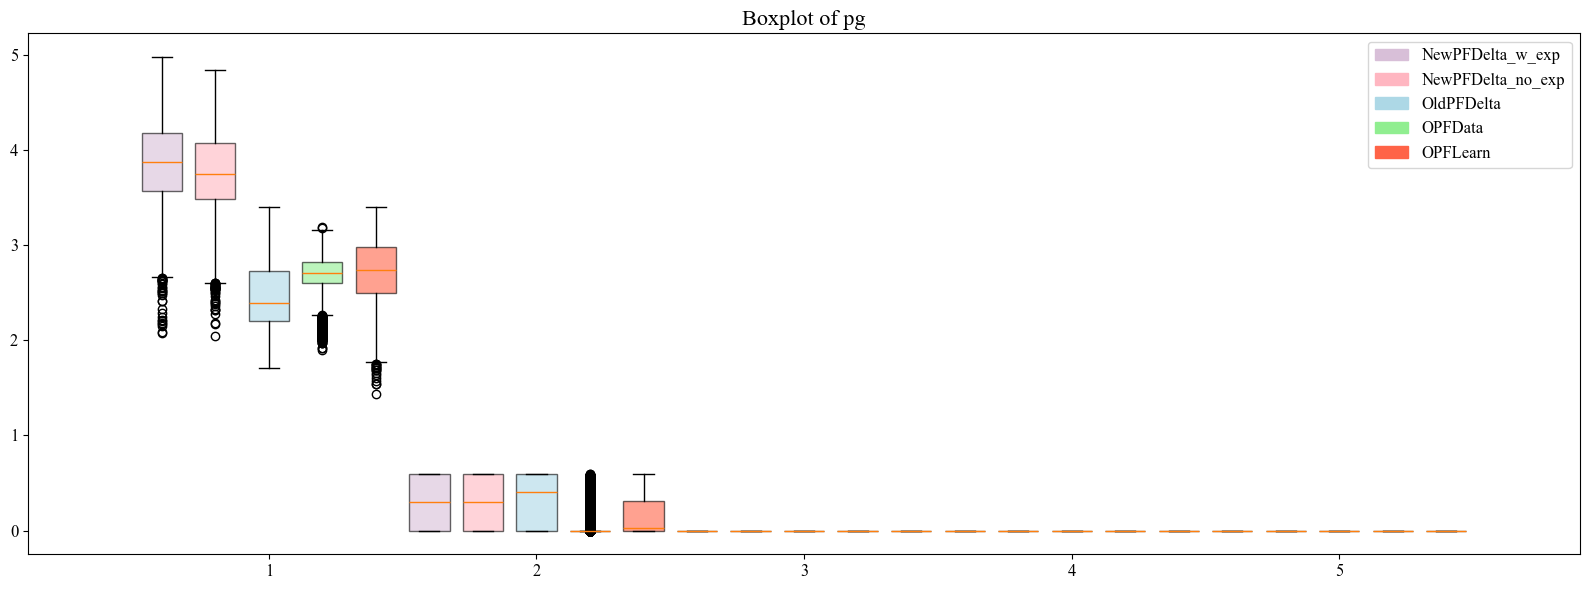

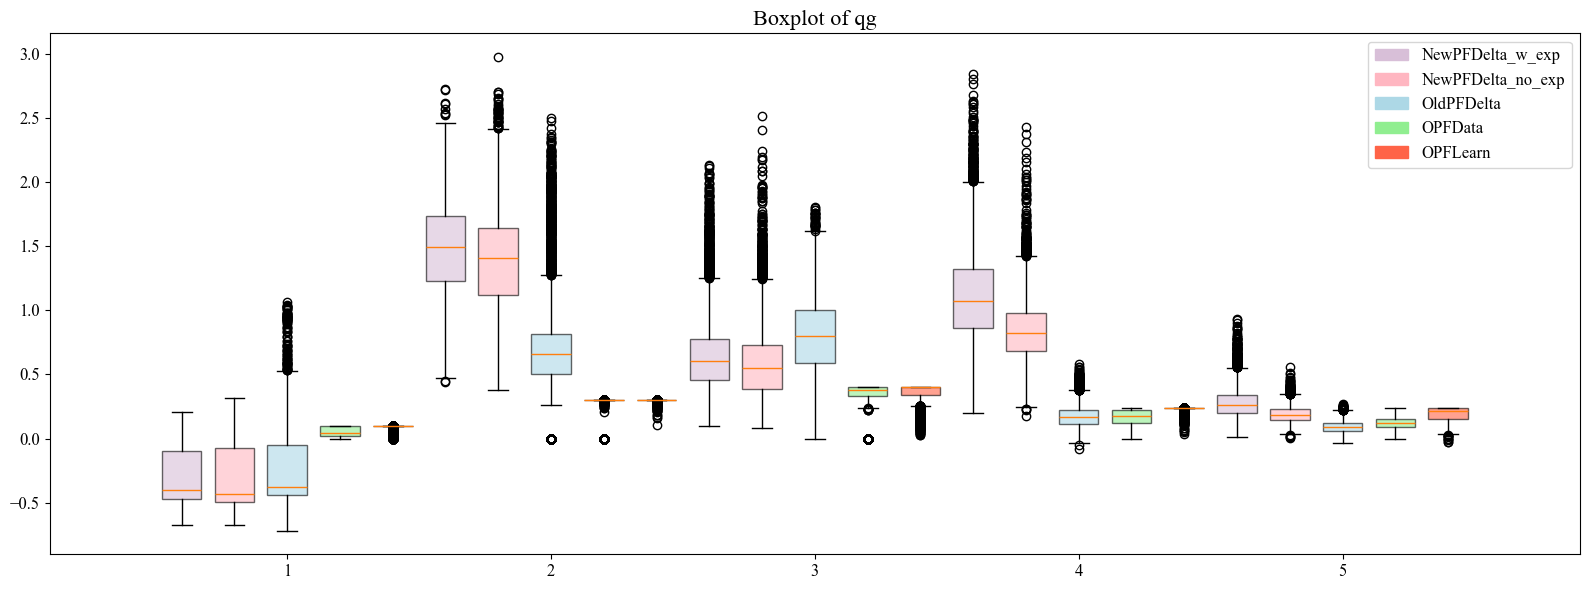

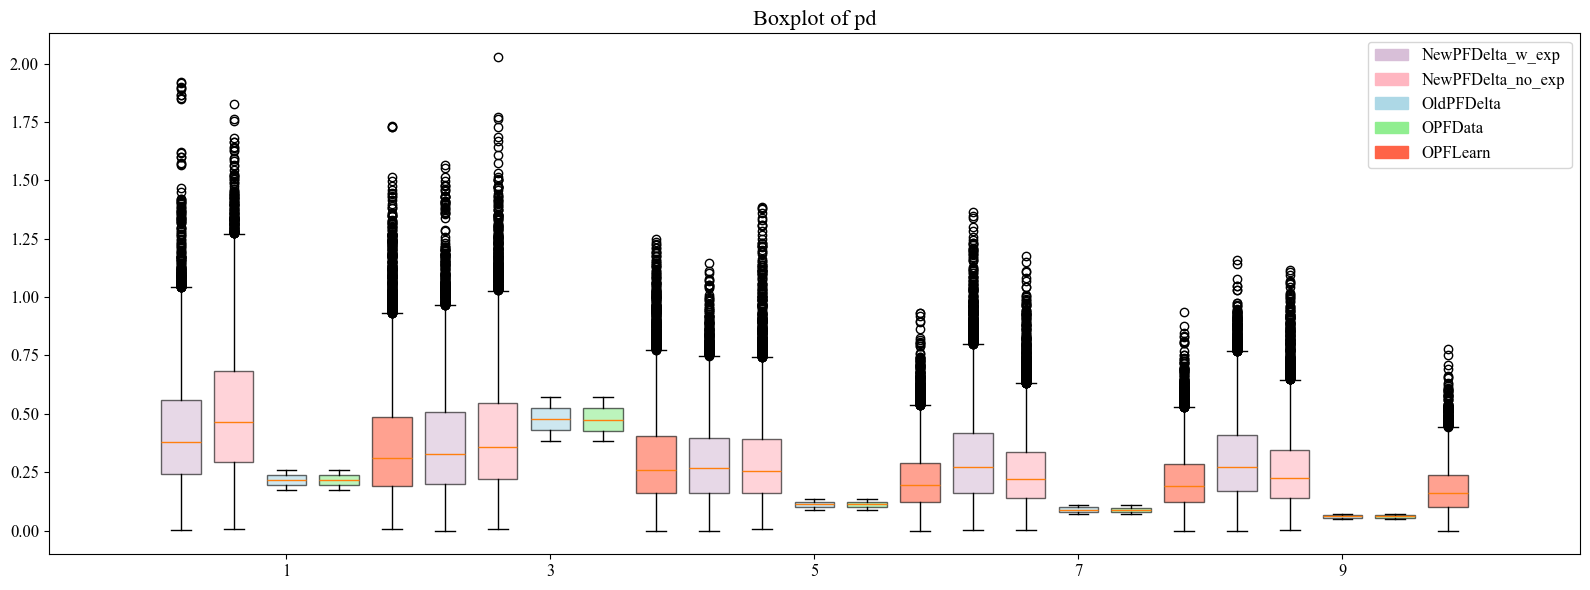

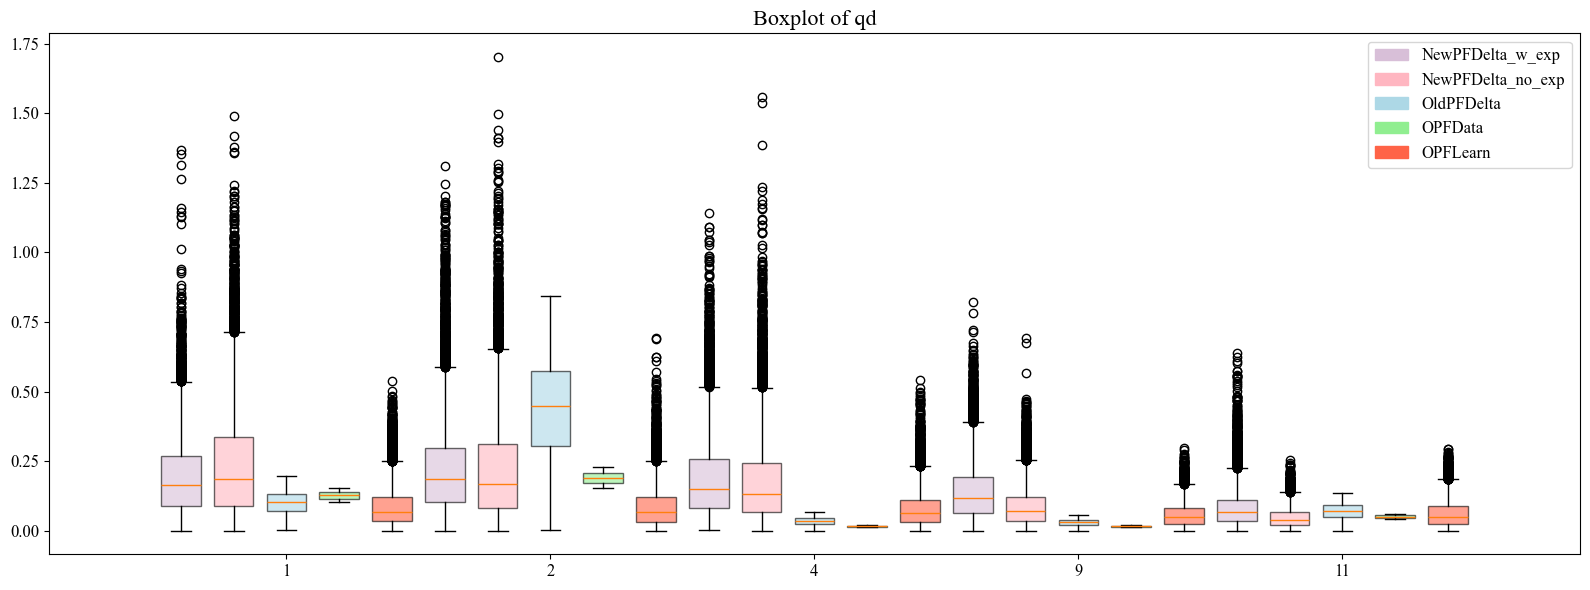

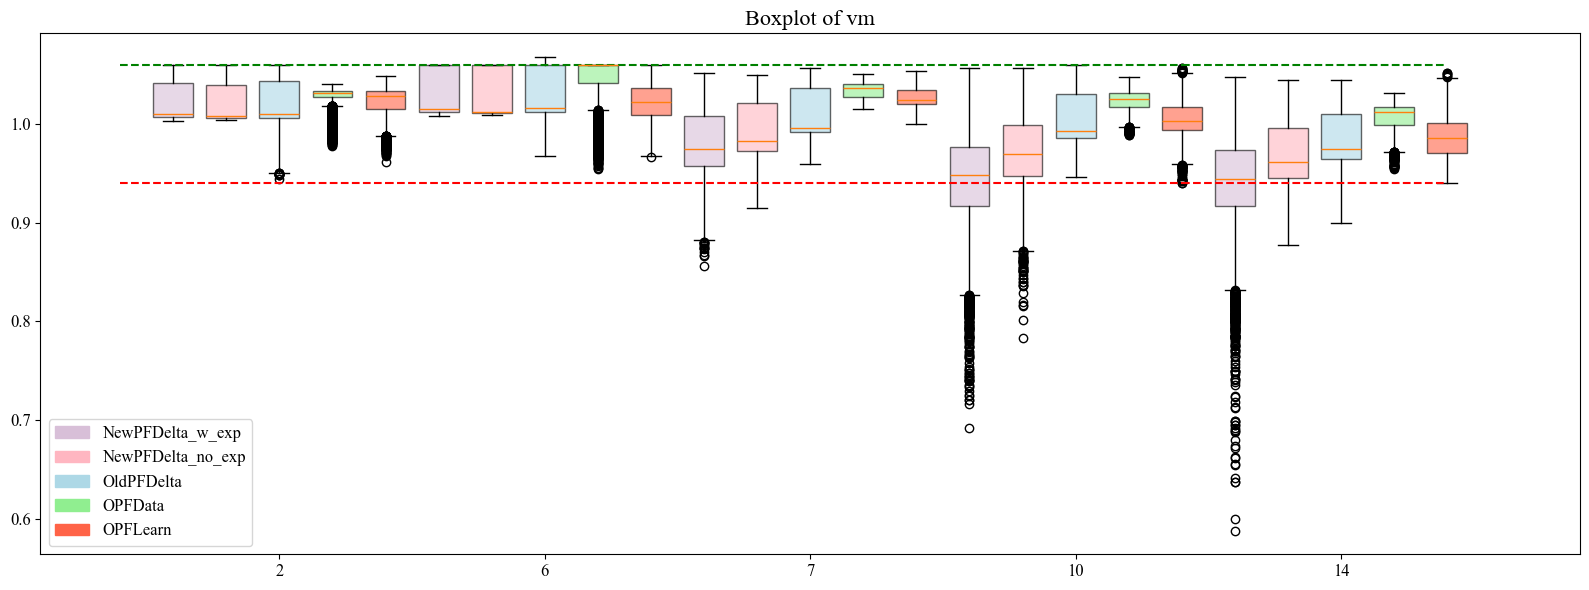

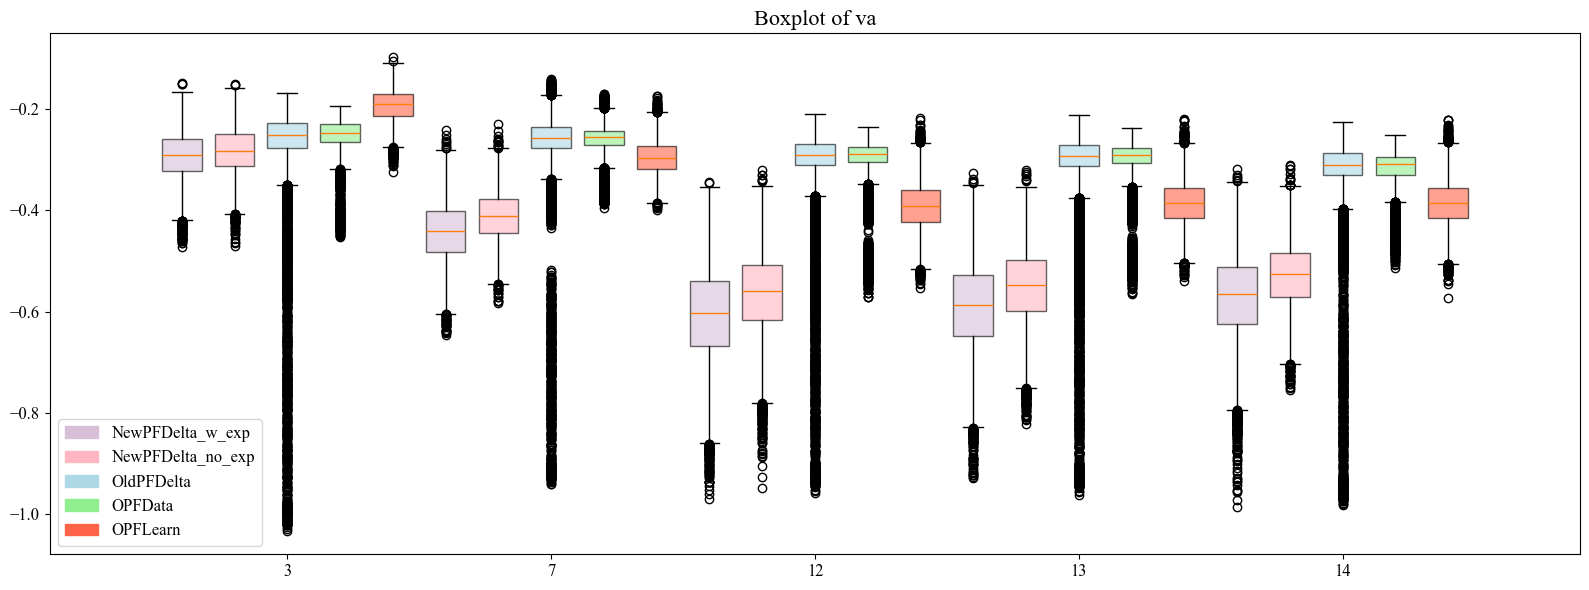

In [102]:
vars_to_plot = {
    "pg": sorted(random.sample(range(num_gens), x_ticks)) if x_ticks < num_gens else list(range(num_gens)),
    "qg": sorted(random.sample(range(num_gens), x_ticks)) if x_ticks < num_gens else list(range(num_gens)),
    "pd": sorted(random.sample(range(num_loads), x_ticks)) if x_ticks < num_loads else list(range(num_loads)),
    "qd": sorted(random.sample(range(num_loads), x_ticks)) if x_ticks < num_loads else list(range(num_loads)),
    "vm": sorted(random.sample(range(num_buses), x_ticks)),
    "va": sorted(random.sample(range(num_buses), x_ticks))
}

colors = ["#D8BFD8", "#FFB6C1", "#ADD8E6", "#90EE90", "#FF6347"]
group_labels = ["NewPFDelta_w_exp", "NewPFDelta_no_exp", "OldPFDelta", "OPFData", "OPFLearn"]
group_data = [new_pfdelta_w_exp, new_pfdelta_no_exp, old_pfdelta, opfdata, opflearn]

for var, indices in vars_to_plot.items():
    data = []
    for i in indices:
        for dataset in group_data:
            data.append(dataset[var][:, i].numpy())

    positions = np.array([np.arange(len(indices)) + i * 0.2 for i in range(len(group_data))]).T.flatten()

    fig, ax = plt.subplots(figsize=(16, 6))
    boxplot = ax.boxplot(data, positions=positions, widths=0.15, showfliers=True, patch_artist=True)

    for i, patch in enumerate(boxplot['boxes']):
        patch.set_facecolor(colors[i % len(colors)])
        patch.set_alpha(0.6)

    xtick_positions = np.arange(len(indices)) + 0.4
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels([f"{i+1}" for i in indices])
    ax.set_title(f"Boxplot of {var}")

    legend_patches = [mpatches.Patch(color=colors[i], label=group_labels[i]) for i in range(len(group_labels))]
    ax.legend(handles=legend_patches, loc="best")

    # Add Vmin/Vmax lines for voltage magnitude
    if var == "vm":
        for idx, bus_idx in enumerate(indices):
            vmin = vmin_array[bus_idx]
            vmax = vmax_array[bus_idx]
            ax.hlines(vmin, idx - 0.2, idx + 0.8, colors='red', linestyles='--', label='Vmin' if idx == 0 else "")
            ax.hlines(vmax, idx - 0.2, idx + 0.8, colors='green', linestyles='--', label='Vmax' if idx == 0 else "")

    plt.tight_layout()
    plt.show()


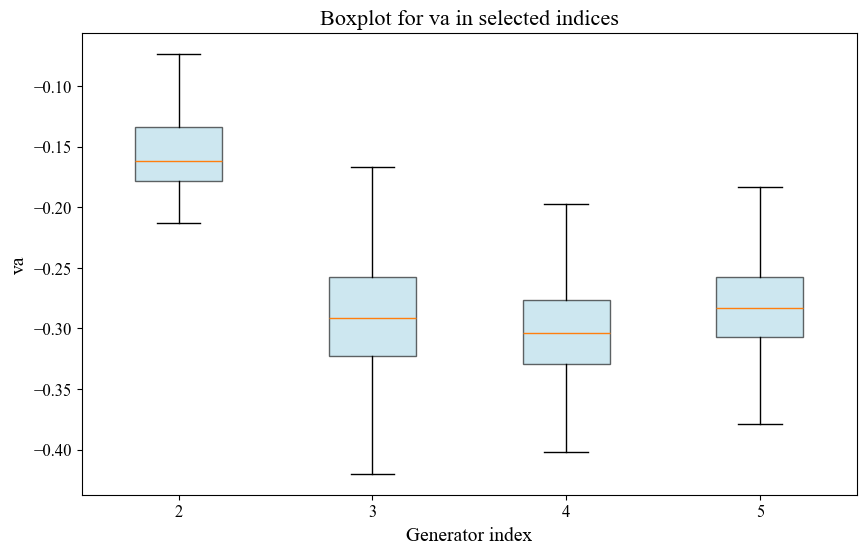

In [103]:
# Cell to look at weird stuff

# Example setup
var = "va"
dataset = new_pfdelta_w_exp  # Choose between new_pfdelta, opfdata, or opflearn
num_buses = dataset["va"].shape[1]  # adjust depending on your case
indices = sorted(random.sample(range(num_gens), 4))  # pick 4 random generators

# Collect the data
data = [dataset[var][:, i].numpy() for i in indices]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
boxplot = ax.boxplot(data, patch_artist=True, showfliers=False)

# Styling (optional)
for patch in boxplot['boxes']:
    patch.set_facecolor("#ADD8E6")  # light blue
    patch.set_alpha(0.6)

# Set x-ticks
ax.set_xticks(np.arange(1, len(indices) + 1))
ax.set_xticklabels([f"{i+1}" for i in indices])

ax.set_title(f"Boxplot for {var} in selected indices")
ax.set_ylabel(var)
ax.set_xlabel("Generator index")

plt.show()

/var/folders/xd/y24vj_hj32x3352849rr9nl80000gn/T/ipykernel_9225/3954173713.py:27: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x='bus', y='value', hue='group', split=True,


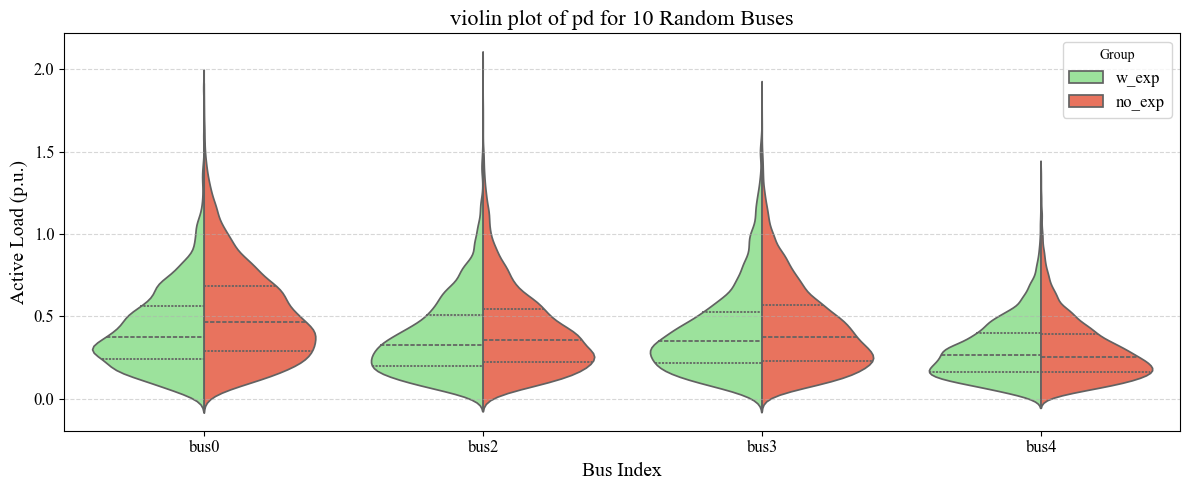

In [104]:
# Extract data
var = 'pd'
pd1 = new_pfdelta_w_exp[ var]
pd2 = new_pfdelta_no_exp[var]
pd1 = pd1.cpu().numpy() if isinstance(pd1, torch.Tensor) else pd1
pd2 = pd2.cpu().numpy() if isinstance(pd2, torch.Tensor) else pd2

n_samples, n_loads = pd1.shape

# Randomly select 10 load buses
np.random.seed(10)
selected_buses = np.random.choice(num_gens, size=4, replace=False)
selected_buses = sorted(selected_buses)

# Stack the data
pd1_selected = pd1[:, selected_buses].flatten()
pd2_selected = pd2[:, selected_buses].flatten()

df = pandas.DataFrame({
    'value': np.concatenate([pd1_selected, pd2_selected]),
    'bus': np.tile([f'bus{i}' for i in selected_buses], 2 * n_samples),
    'group': ['w_exp'] * (n_samples * len(selected_buses)) + ['no_exp'] * (n_samples * len(selected_buses))
})

# Plot
plt.figure(figsize=(12, 5))
sns.violinplot(data=df, x='bus', y='value', hue='group', split=True,
               inner='quartile', scale='width', palette={"w_exp": "#90EE90", "no_exp": "#FF6347"})

plt.title(f"violin plot of {var} for 10 Random Buses")
plt.ylabel("Active Load (p.u.)")
plt.xlabel("Bus Index")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend(title='Group')
plt.show()


/var/folders/xd/y24vj_hj32x3352849rr9nl80000gn/T/ipykernel_9225/3890754667.py:21: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df_vm, x='bus', y='value', scale='width', inner='quartile')


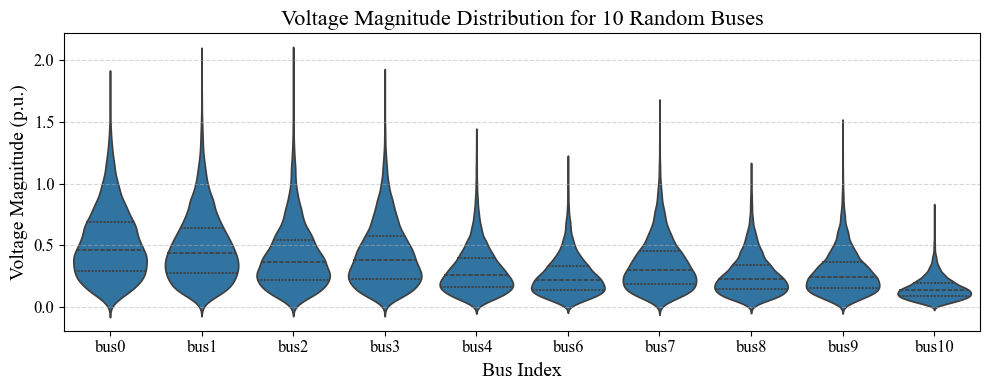

In [105]:
vm = new_pfdelta_no_exp['pd']  # shape: [n_samples, n_buses]
vm = vm.cpu().numpy() if isinstance(vm, torch.Tensor) else vm

n_samples, n_buses = vm.shape

# Randomly select 10 unique bus indices
np.random.seed(0)  # for reproducibility (optional)
selected_buses = np.random.choice(n_buses, size=10, replace=False)
selected_buses = sorted(selected_buses)  # optional, for nicer plotting

# Extract the corresponding columns
vm_selected = vm[:, selected_buses]

# Build long-form DataFrame
df_vm = pandas.DataFrame({
    'value': vm_selected.flatten(),
    'bus': [f'bus{i}' for i in selected_buses] * n_samples
})

plt.figure(figsize=(10, 4))
sns.violinplot(data=df_vm, x='bus', y='value', scale='width', inner='quartile')
plt.title('Voltage Magnitude Distribution for 10 Random Buses')
plt.ylabel('Voltage Magnitude (p.u.)')
plt.xlabel('Bus Index')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()